[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/kmaussang/JupyterNotebookPhysics/main?filepath=Circuit%20RC.ipynb)

# Etude d'un circuit RC

## Import des modules python

In [26]:
import numpy as np
import scipy.integrate as itg
import matplotlib.pyplot as plt
import random
from matplotlib import rc
rc('text', usetex=True)

In [9]:
from importlib.metadata import version
version('numpy')

'1.26.4'

In [10]:
version('scipy')

'1.13.1'

In [11]:
version('matplotlib')

'3.9.2'

## Paramètres du circuit

In [12]:
R=1e3 # en Ohms
C=1e-6 # en Farad

if R*C>0.1:
    print("Constante de temps du circuit, RC={:.2f}s".format(R*C))
elif R*C>1e-4:
    print("Constante de temps du circuit, RC={:.2f}ms".format(R*C*1e3))
elif R*C>1e-7:
    print("Constante de temps du circuit, RC={:.2f}µs".format(R*C*1e6))     
else:
    print("Constante de temps du circuit, RC={:.3f}ns".format(R*C*1e9))

Constante de temps du circuit, RC=1.00ms


## Réponse à un échelon de tension

### Définition de la tension d'excitation
La tension aux bornes du condensateur $u(t)$ est régie par l'équation différentielle suivante
$$ u(t) + \tau\frac{\text{d}u(t)}{\text{d}t}=E(t),$$ où $E(t)$ est la tension excitatrice et $\tau=RC$. Cette équation peut s'écrire comme suit $$\frac{\text{d}u(t)}{\text{d}t}=\frac{E(t)-u(t)}{\tau}.$$
Cette forme est adaptée pour une résolution numérique avec le module `scipy.integrate.odeint`. Ce module permet de résoudre une équation différentielle de la forme `dy/dt = func(y, t0, ...)` où `y` est un vecteur, `t_0` un instant initial et `func()` une fonction préalablement définie. On va ainsi définir une fonction `du(t)` adaptée à cette syntaxe. 


In [13]:
slope=1 # type d'échelon +1/-1
Emax=5 # amplitude (en Volt)
u0=Emax*(1-slope)/2 # tension initiale aux bornes du condensateur, en Volt
    

def E(t):
    if slope==1:
        if t<0 :
            return 0.0
        else :
            return Emax
    elif slope==-1:
        if t>0 :
            return 0.0
        else :
            return Emax
    else:
        print("Mauvaise valeur du paramètre 'slope'")
        pass

def dUc(Uc, t):
    return (E(t)-Uc)/tau

### Intégraton de l'équation différentielle

In [14]:
tau=R*C
t=np.linspace(-tau,10*tau,400) # vecteur de temps
Uc = itg.odeint(dUc, [u0], t)
Eref=np.array([E(x) for x in t])

### Représentation graphique

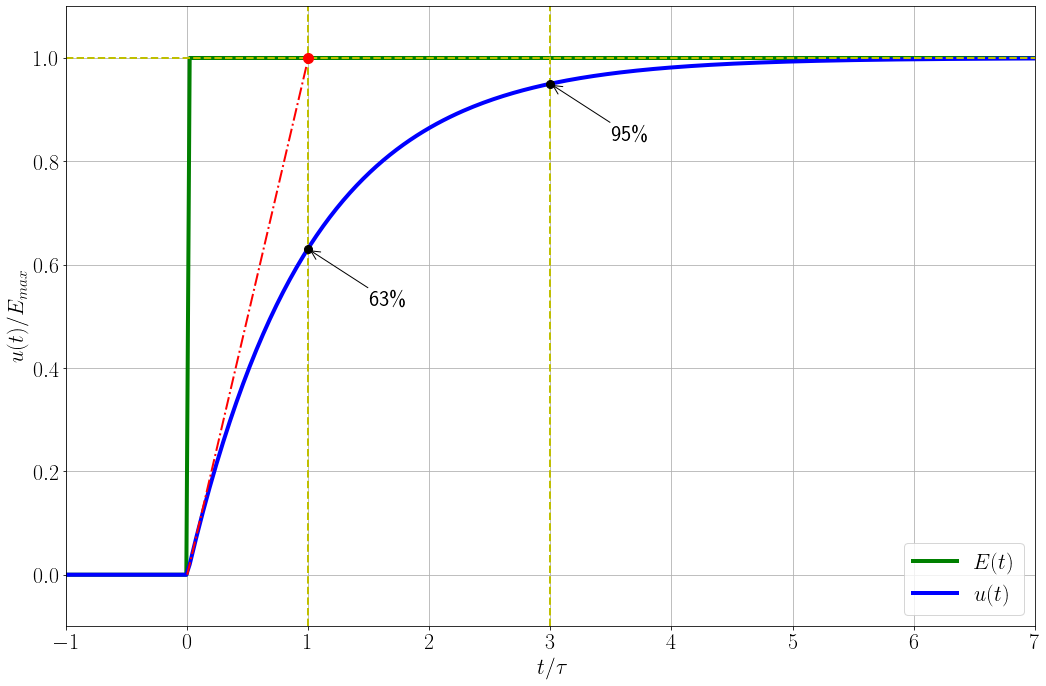

In [15]:
fig=plt.figure(1, figsize=(15, 10))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(t/tau,Eref/Emax,"g-", linewidth=4)
plt.plot(t/tau,Uc/Emax,"b-", linewidth=4)
plt.legend([r'$E(t)$',r'$u(t)$'])
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$u(t)/E_{max}$ ')
plt.grid()
plt.plot([ -1, 10 ], [(1+slope)/2, (1+slope)/2], "y--", linewidth=2)
plt.plot([ 1, 1 ], [-.1, 1.10 ], "y--", linewidth=2)
plt.plot([ 3, 3 ], [-.1, 1.10 ], "y--", linewidth=2)
plt.plot([ 0, 1 ], [ (1-slope)/2, (1+slope)/2 ], "r-.", linewidth=2)
plt.plot([1],[(1+slope)/2],'o',color='red',markersize=10)
plt.plot([1],[(1-slope)/2+slope*.63],'o',color='black',markersize=8)
plt.plot([3],[(1-slope)/2+slope*.95],'o',color='black',markersize=8)
plt.annotate("63\%", (1, (1-slope)/2+slope*0.63), (1.5, (1-slope)/2+slope*0.52), arrowprops={"arrowstyle":"->"})
plt.annotate("95\%", (3, (1-slope)/2+slope*0.95), (3.5, (1-slope)/2+slope*0.84), arrowprops={"arrowstyle":"->"})
plt.xlim(-1,7)
plt.ylim(-0.1,1.1)
plt.tight_layout()
plt.show()

## Cas d'une excitation sinusoïdale

On considère désormais une excitation sinusoïdale de fréquence $f$, de la forme $E(t<0)=0$ et $E(t>0)=E_{max} (\sin 2 \pi f t)$.

### Définition de la fonction d'excitation et intégration

In [16]:
Emax=5 # amplitude (en Volt)
u0=0 # tension initiale aux bornes du condensateur, en Volt
f=1e3 # frequence en Hz

def E(t):
    if t<0 :
        return 0.0
    else :
        return Emax*np.sin(2*np.pi*f*t)

def dUc(Uc, t):
    return (E(t)-Uc)/tau

t=np.linspace(-tau,10*tau,400) # vecteur de temps
Uc = itg.odeint(dUc, [u0], t)
Eref=np.array([E(x) for x in t])

### Représentation graphique

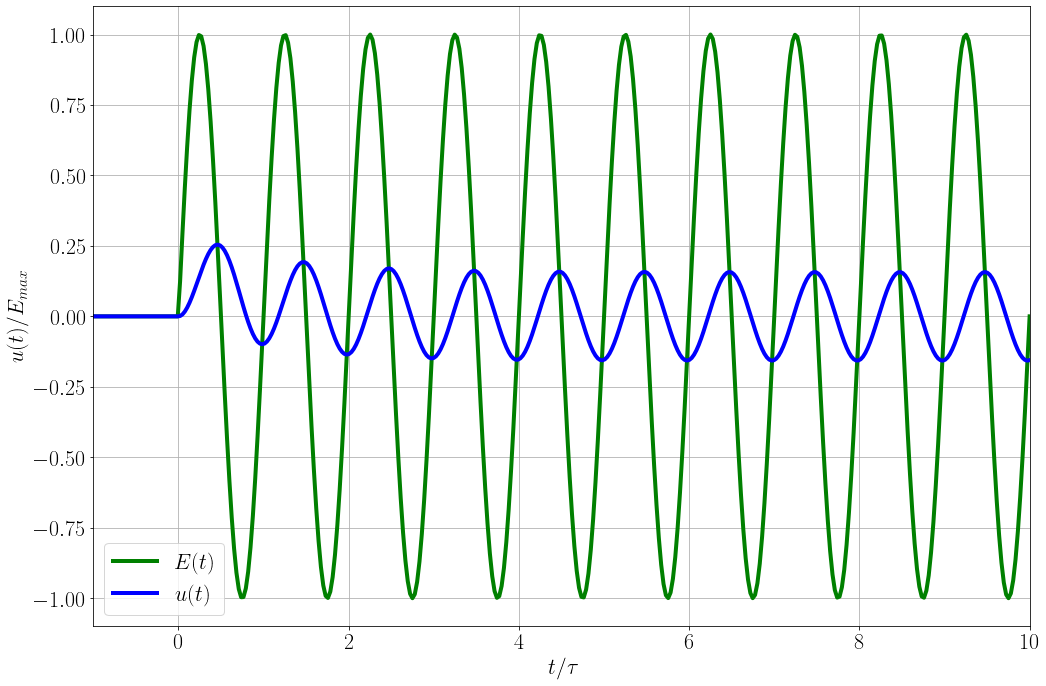

In [17]:
fig=plt.figure(1, figsize=(15, 10))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(t/tau,Eref/Emax,"g-", linewidth=4)
plt.plot(t/tau,Uc/Emax,"b-", linewidth=4)
plt.legend([r'$E(t)$',r'$u(t)$'])
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$u(t)/E_{max}$ ')
plt.grid()
plt.xlim(-1,10)
plt.ylim(-1.1,1.1)
plt.tight_layout()
plt.show()

## Cas d'une excitation créneau

### Définition de la fonction d'excitation et intégration

In [18]:
Emax=5 # amplitude (en Volt)
u0=0 # tension initiale aux bornes du condensateur, en Volt
f=2e3 # frequence en Hz

def E(t):
    if t<0 :
        return 0.0
    elif Emax*np.sin(2*np.pi*f*t)>0:
        return Emax
    else:
        return 0.0
    
def dUc(Uc, t):
    return (E(t)-Uc)/tau

t=np.linspace(-tau,10*tau,400) # vecteur de temps
Uc = itg.odeint(dUc, [u0], t)
Eref=np.array([E(x) for x in t])

### Représentation graphique

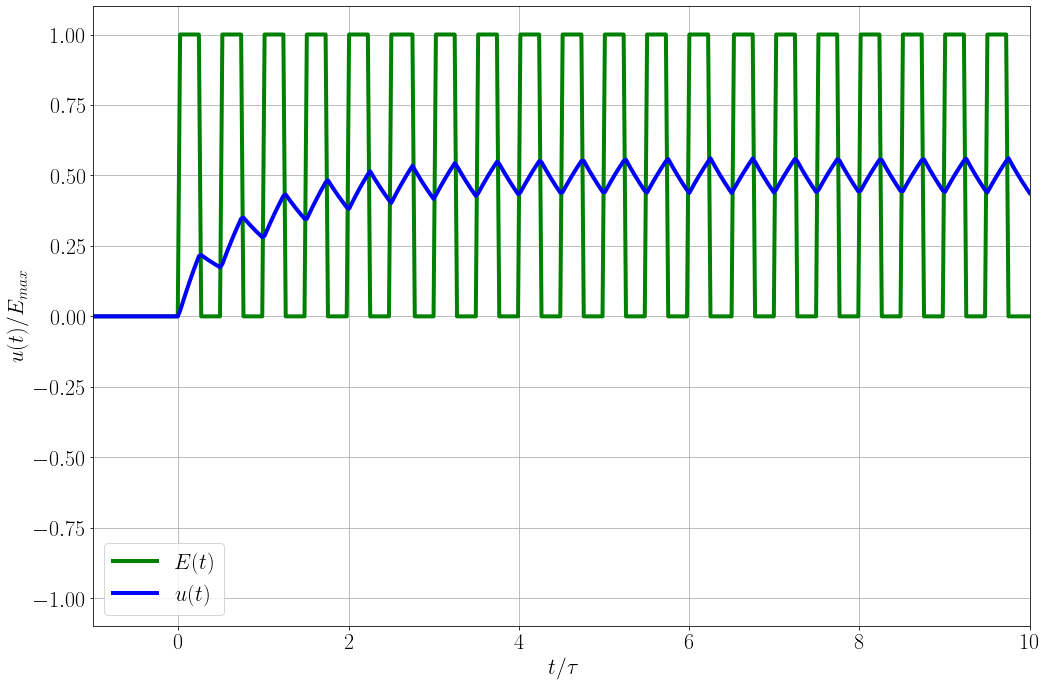

In [19]:
fig=plt.figure(1, figsize=(15, 10))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(t/tau,Eref/Emax,"g-", linewidth=4)
plt.plot(t/tau,Uc/Emax,"b-", linewidth=4)
plt.legend([r'$E(t)$',r'$u(t)$'])
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$u(t)/E_{max}$ ')
plt.grid()
plt.xlim(-1,10)
plt.ylim(-1.1,1.1)
plt.tight_layout()
plt.show()

## Cas d'un signal binaire

### Définition du signal d'entrée

In [20]:
Emax=5 # amplitude (en Volt)
u0=0 # tension initiale aux bornes du condensateur, en Volt
dt=5000e-6 # pas temporel en s
Ttot=40*dt
t=np.linspace(-Ttot/40,Ttot,500) # vecteur de temps

Nsamp=round(Ttot/dt)
t_start=dt*np.array(random.sample(range(Nsamp),round(0.55*Nsamp)))
t_start=np.sort(t_start-min(t_start))

In [21]:
def E(t):
    tmp=0
    for x in t_start:
        tmp +=np.heaviside(t-x, 0)-np.heaviside(t-x-dt, 0) 
    return Emax*tmp

### Représentation graphique du signal binaire

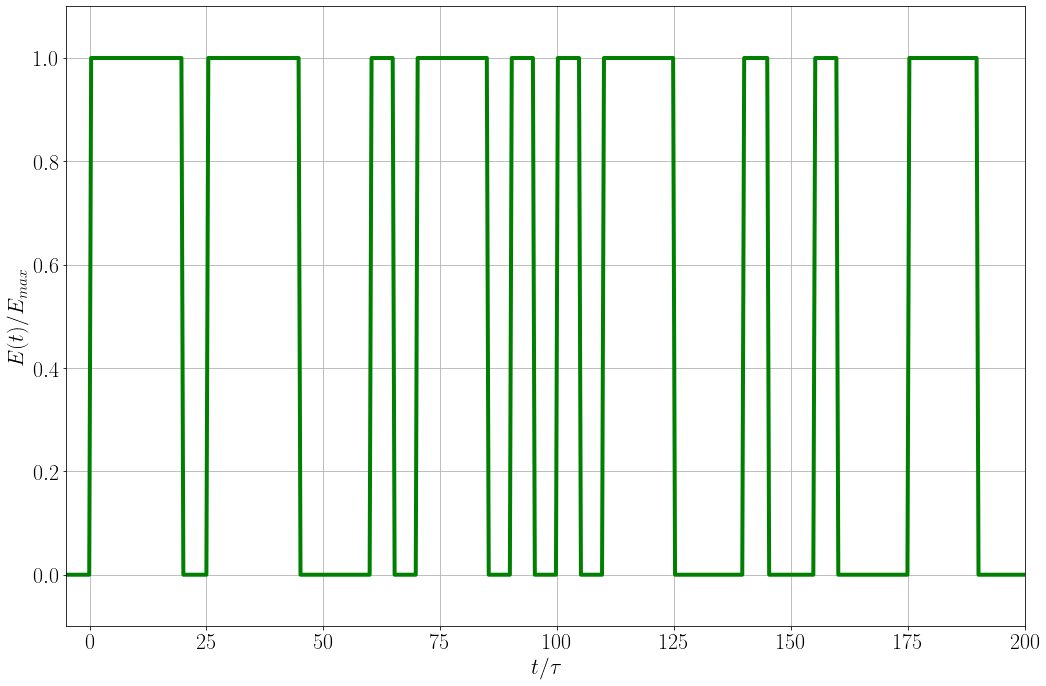

In [22]:
fig=plt.figure(1, figsize=(15, 10))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(t/tau,E(t)/Emax,"g-", linewidth=4)
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$E(t)/E_{max}$ ')
plt.grid()
plt.xlim(-Ttot/(40*tau),Ttot/tau)
plt.ylim(-0.1,1.1)
plt.tight_layout()
plt.show()

### Intégration

In [23]:
def dUc(Uc, t):
    return (E(t)-Uc)/tau

Uc = itg.odeint(dUc, [u0], t)
Eref=np.array([E(x) for x in t])

# attention instable, bug sur le solver. Changer de solver avec un pas temporel controlable ?

### Représentation graphique

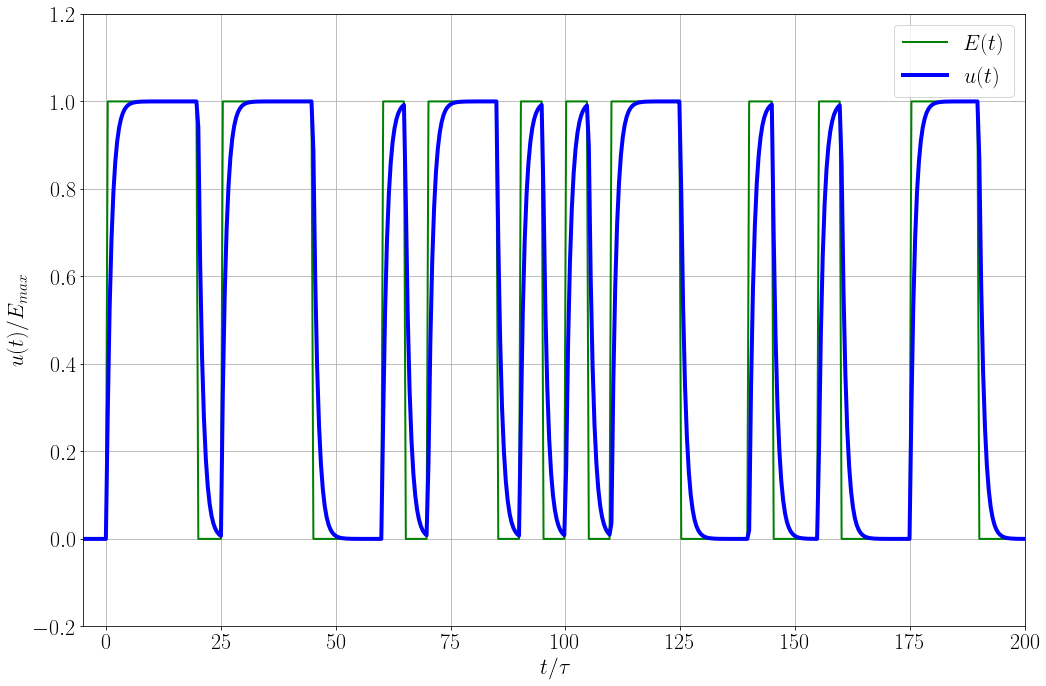

In [24]:
fig=plt.figure(1, figsize=(15, 10))
plt.rcParams.update({'font.size': 22}) # change font size
plt.plot(t/tau,Eref/Emax,"g-", linewidth=2)
plt.plot(t/tau,Uc/Emax,"b-", linewidth=4)
plt.legend([r'$E(t)$',r'$u(t)$'],loc='best')
plt.xlabel(r'$t/\tau$')
plt.ylabel(r'$u(t)/E_{max}$ ')
plt.grid()
plt.xlim(-Ttot/(40*tau),Ttot/tau)
plt.ylim(-0.2,1.2)
plt.tight_layout()
plt.show()